This code will execute from the
#/content
directory. 

This is also where you need to put your data files or else the programs won't be able to run.

Make sure you run the library installation section (below) or else you may not be able to run the code. 

In [2]:
! pip install iminuit
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install emcee
! pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Part 2: MC data generation , Statistics and Fitting

Now we will do multiple things in the code that follows.

1.) We will generate four datasets "databases" that come from random variation on a line.

2.) The random variation will be as follows:

--a.) Gaussian random of parameters

--b.) Beta random of parameters

--c.) Gaussian+Beta convolution random of parameters

--d.) Stochastic Gaussian random, independent of parameters

3.) We will compute residual, pulls, permutation test to test and visualize the data

4.) We will fit with linear regression, least squares and error propagated least log likelihood

5.) We will also run emcee (Markov Chain Monte Carlo or MCMC) fitting

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Investigate the code below , particularly the functions

Precision given: 1.00e-03
Parameters for beta random numbers
-----
alpha = 1.00e+03 
beta = 1.00e+00 
Precision for stochastic gaussian noise
-----
sigma = 5.00e-03
0.9871012898710129
-----
Pvalues from the permutation tests
Database 1: 9.87101e-01
Database 2: 3.30367e-01
Database 3: 3.29567e-01
Database 4: 9.93301e-01


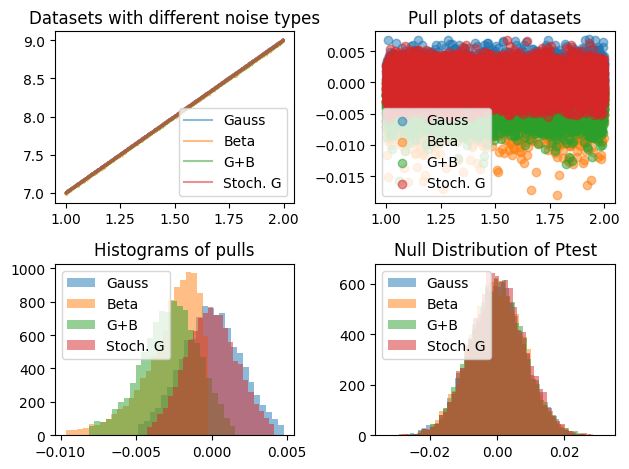

-----
Database 1 linear regression fit
m = 2.00036e+00 +- 2.02953e-04, b = 4.99940e+00 +- 3.10017e-04
Database 1 p-value 0.00000e+00
-----
Database 2 linear regression fit
m = 1.99781e+00 +- 2.01583e-04, b = 4.99532e+00 +- 3.07925e-04
Database 2 p-value 0.00000e+00
-----
Database 3 linear regression fit
m = 1.99793e+00 +- 1.99975e-04, b = 4.99517e+00 +- 3.05468e-04
Database 3 p-value 0.00000e+00
-----
Database 4 linear regression fit
m = 2.00002e+00 +- 1.74577e-04, b = 4.99993e+00 +- 2.66672e-04
Database 4 p-value 0.00000e+00
-----
Database 1 non-linear least squares fit
m = 2.00036e+00 $\pm$ 2.02953e-04 
b = 4.99940e+00 $\pm$ 3.10017e-04
Database 1 covariance matrix
[[ 4.11899792e-08 -6.17849683e-08]
 [-6.17849683e-08  9.61106365e-08]]
-----
Database 2 non-linear least squares fit
m = 1.99781e+00 $\pm$ 2.01583e-04 
b = 4.99532e+00 $\pm$ 3.07925e-04
Database 2 covariance matrix
[[ 4.06358694e-08 -6.09538042e-08]
 [-6.09538042e-08  9.48177063e-08]]
-----
Database 3 non-linear least squa

<ipython-input-6-49ec70e3d61d>:182: OptimizeWarning: Unknown solver options: fatol
  res = minimize(fun_LL_line,PINIT,method='L-BFGS-B',tol=1e-30, options={'fatol': 1e-30})


-----
Database 1 2D log likelihood for the parameters and their uncertainties
m = 4.99949e+00 $\pm$ 4.91872e-03 
b = 2.00030e+00 $\pm$ 2.08280e-03
Hessian inverse (covariance matrix)
[[ 0.06720197  0.00047862  0.06945608 -0.05958073]
 [ 0.00047862  0.00060518  0.00025371  0.00070896]
 [ 0.06945608  0.00025371  0.1018085  -0.0991391 ]
 [-0.05958073  0.00070896 -0.0991391   0.1009667 ]]
-----
Database 2 2D log likelihood for the parameters and their uncertainties
m = 4.99530e+00 $\pm$ 4.69313e-03 
b = 1.99783e+00 $\pm$ 2.25141e-03
Hessian inverse (covariance matrix)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
-----
Database 3 2D log likelihood for the parameters and their uncertainties
m = 4.99514e+00 $\pm$ 4.83659e-03 
b = 1.99795e+00 $\pm$ 2.06251e-03
Hessian inverse (covariance matrix)
[[13.59771529 -9.41121198  0.52026454  1.28618595]
 [-9.41121198  6.52732243 -0.27570654 -0.81636662]
 [ 0.52026454 -0.27570654  0.54764135  0.51353119]
 [ 1.28618595 -0.81636662  0.513

In [6]:
#Author: Brendon Madison , brendon_madison@ku.edu

import numpy as np
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm, linregress, permutation_test
import matplotlib.pyplot as plt

#Generate model data
yinter = 5.0
slope = 2.0
num = 10000
pre = 1000e-6
alph = 1000 #If you are assuming this data is binomial then alpha really should be = to num here

print("Precision given: %0.2e" % pre)


#Data generator function for generating three data sets
#Generate set 1 with parameter precision of 1000 ppm and normal distribution
#Generate set 2 with parameter precision of 1000 ppm and beta distribution
#Generate set 3 with parameter precision of 1000 ppm with half from beta distribution, half from normal distribution
#Generate set 4 with stochastic noise of normal distribution with constant amplitude of 1000 pm * YINT
#This one is for generating a line
def data_gen_linear(PRECISION,ALPHA,YINT,SLOPE,XAXIS,NUMPTS):
    #data points
    dp = np.ones(NUMPTS)*YINT + XAXIS*SLOPE
    #Datasets to be generated
    ds1 = []
    ds2 = []
    ds3 = []
    ds4 = []

    #Beta parameter values for the beta distributions
    bta = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION - 
        ALPHA*PRECISION*PRECISION)/(ALPHA*PRECISION*PRECISION - 1.0)
    bta3 = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION*2.0 - 
        ALPHA*PRECISION*PRECISION*2.0)/(ALPHA*PRECISION*PRECISION*2.0 - 1.0)
    #1-sigma amplitude of gaussian noise
    rg_amp = PRECISION*YINT

    print("Parameters for beta random numbers\n-----\nalpha = %0.2e \nbeta = %0.2e " % (alph,bta))
    print("Precision for stochastic gaussian noise\n-----\nsigma = %0.2e" % (rg_amp))

    #now we do a for loop to fill the datasets
    for i in range(len(dp)):
        ds1.append(np.random.normal(YINT,YINT*PRECISION,1) + 
            XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION,1))
        ds2.append(np.random.beta(ALPHA,bta,1)*YINT + 
            XAXIS[i]*np.random.beta(ALPHA,bta,1)*SLOPE)
        ds3.append(np.random.beta(ALPHA,bta3,1)*YINT*0.5 + 
            XAXIS[i]*np.random.beta(ALPHA,bta3,1)*SLOPE*0.5 + 
            np.random.normal(YINT,YINT*PRECISION*np.sqrt(2.0),1)*0.5 + 
            XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION*np.sqrt(2.0),1)*0.5)
        ds4.append(YINT + XAXIS[i]*SLOPE + 
            np.random.normal(0.0,rg_amp))
    ds1 = np.array(ds1).flatten()
    ds2 = np.array(ds2).flatten()
    ds3 = np.array(ds3).flatten()
    ds4 = np.array(ds4).flatten()
    return dp,ds1,ds2,ds3,ds4
    
def data_gen_para(PRECISION,ALPHA,YINT,SLOPE,XAXIS,NUMPTS):
    #data points
    dp = np.ones(NUMPTS)*YINT + XAXIS*XAXIS*SLOPE
    #Datasets to be generated
    ds1 = []
    ds2 = []
    ds3 = []
    ds4 = []

    #Beta parameter values for the beta distributions
    bta = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION - 
        ALPHA*PRECISION*PRECISION)/(ALPHA*PRECISION*PRECISION - 1.0)
    bta3 = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION*2.0 - 
        ALPHA*PRECISION*PRECISION*2.0)/(ALPHA*PRECISION*PRECISION*2.0 - 1.0)
    #1-sigma amplitude of gaussian noise
    rg_amp = PRECISION*YINT

    print("Parameters for beta random numbers\n-----\nalpha = %0.2e \nbeta = %0.2e " % (alph,bta))
    print("Precision for stochastic gaussian noise\n-----\nsigma = %0.2e" % (rg_amp))

    #now we do a for loop to fill the datasets
    for i in range(len(dp)):
        ds1.append(np.random.normal(YINT,YINT*PRECISION,1) + 
            XAXIS[i]*XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION,1))
        ds2.append(np.random.beta(ALPHA,bta,1)*YINT + 
            XAXIS[i]*XAXIS[i]*np.random.beta(ALPHA,bta,1)*SLOPE)
        ds3.append(np.random.beta(ALPHA,bta3,1)*YINT*0.5 + 
            XAXIS[i]*XAXIS[i]*np.random.beta(ALPHA,bta3,1)*SLOPE*0.5 + 
            np.random.normal(YINT,YINT*PRECISION*np.sqrt(2.0),1)*0.5 + 
            XAXIS[i]*XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION*np.sqrt(2.0),1)*0.5)
        ds4.append(YINT + XAXIS[i]*XAXIS[i]*SLOPE + 
            np.random.normal(0.0,rg_amp))
    ds1 = np.array(ds1).flatten()
    ds2 = np.array(ds2).flatten()
    ds3 = np.array(ds3).flatten()
    ds4 = np.array(ds4).flatten()
    return dp,ds1,ds2,ds3,ds4



#For fitting and estimating the uncertainty of both parameters
#assumes a linear function: b + m*x
def fun_LL_line(params):
    #predicted y value
    yPred = params[0] + xdat*params[1]
    #The propagated variance
    #we assume that there is no uncertainty in x
    #we also assume our values are independent
    #You have to compute this using stuff like https://en.wikipedia.org/wiki/Propagation_of_uncertainty
    yVar = params[2]*params[2] + params[3]*params[3]*xdat*xdat
    LL = -np.sum(norm.logpdf(ydat,loc=yPred,scale=np.sqrt(yVar)))
    return(LL)
    
#For fitting and estimating the uncertainty of both parameters
#assumes a parabolic function: a + b*x*x
def fun_LL_para(params):
    #predicted y value
    yPred = params[0] + xdat*xdat*params[1]
    #The propagated variance
    #we assume that there is no uncertainty in x
    #we also assume our values are independent
    #You have to compute this using stuff like https://en.wikipedia.org/wiki/Propagation_of_uncertainty
    yVar = params[2]*params[2] + params[3]*params[3]*xdat*xdat*xdat*xdat
    LL = -np.sum(norm.logpdf(ydat,loc=yPred,scale=np.sqrt(yVar)))
    return(LL)
    
#For fitting and estimating the uncertainty of both parameters
#assumes a beta distribution: x^(a-1) * (1-x)^(b-1)
def fun_LL_beta(params):
    #predicted y value
    yPred = xdat**(params[0]-1.0) * (1.0-xdat)**(params[1] - 1.0)
    #the normalization
    yPred = yPred/np.amax(yPred)
    #The propagated variance
    #we assume that there is no uncertainty in x
    #we also assume our values are independent
    #You have to compute this using stuff like https://en.wikipedia.org/wiki/Propagation_of_uncertainty
    #Since this is a difficult equation just use wolfram alpha!
    alphvar = params[2]*params[2] * ((xdat**(params[0] - 1.0) * (1.0-xdat)**(params[1]) * np.log(xdat))/(xdat-1.0))**2
    betavar = params[3]*params[3] * ((xdat**(params[0] - 1.0) * (1.0-xdat)**(params[1]) * np.log(1.0-xdat))/(xdat-1.0))**2
    yVar = alphvar + betavar
    LL = -np.sum(norm.logpdf(ydat,loc=yPred,scale=np.sqrt(yVar)))
    return(LL)

def func(x,a,b):
    return a*x + b


def fit_linreg(XAXIS,DATABASE,NAME):
    #Scipy's least squares fit (linear regression)
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    lr = linregress(XAXIS,DATABASE)
    print("-----")
    print("%s linear regression fit" % NAME)
    print("m = %0.5e +- %0.5e, b = %0.5e +- %0.5e" % (lr.slope,lr.stderr,lr.intercept,lr.intercept_stderr))
    print("%s p-value %0.5e" % (NAME,lr.pvalue))
    
def fit_lsq(XAXIS,DATABASE,PINIT,NAME):
    #Scipy's optimize non-linear least squares fit
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    popt, pcov = curve_fit(func,XAXIS,DATABASE,p0=PINIT)

    print("-----")
    print("%s non-linear least squares fit" % NAME)
    print("m = %0.5e $\pm$ %0.5e \nb = %0.5e $\pm$ %0.5e" % (popt[0],np.sqrt(pcov[0][0]),popt[1],np.sqrt(pcov[1][1])))
    print("%s covariance matrix" % NAME)
    print(pcov)    

def fit_LL(XAXIS,DATABASE,PINIT,NAME):
    #Compute the fit using scipy's minimize with a user define function
    #Minimize https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    #also reference for the res variable https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
    #Setting these global variables sets the values in the fit function
    global ydat 
    ydat = DATABASE
    global xdat 
    xdat = XAXIS
    #We use the user defined fun_LL_line which computes log likelihood for a line and uncertainty on both parameters
    #By using the 'L-BFGS-B' method scipy can calculate the inverse hessian matrix (covariance matrix)
    #Though sometimes it will fail!
    res = minimize(fun_LL_line,PINIT,method='L-BFGS-B',tol=1e-30, options={'fatol': 1e-30})
    #res = minimize(fun_LL_para,PINIT,method='L-BFGS-B',tol=1e-30, options={'fatol': 1e-30})

    print("-----")
    print("%s 2D log likelihood for the parameters and their uncertainties" % NAME)
    print("m = %0.5e $\pm$ %0.5e \nb = %0.5e $\pm$ %0.5e" % (res.x[0],np.abs(res.x[2]),res.x[1],np.abs(res.x[3])))
    print("Hessian inverse (covariance matrix)")
    #Sometimes this can't be computed and will be an identity matrix!
    print(res.hess_inv.todense())

def data_get_pulls(FIT,DATABASE,ERR):
    #Takes the error value, the fit output and the database values
    #FIT and DATABASE should be arrays (or lists) of same length
    #ERR can be an array of same length OR a singular value
    #Computes the residuals R = DATABASE-FIT
    #and computes the pulls P = R/ERR
    res = []
    pull = []
    if len(ERR) == 1:
        for i in range(len(d1)):
            res.append(DATABASE[i] - FIT[i])
            pull.append((DATABASE[i] - FIT[i])/ERR)
    else:
        for i in range(len(d1)):
            res.append(DATABASE[i] - FIT[i])
            pull.append((DATABASE[i] - FIT[i])/ERR[i])
    return np.array(res), np.array(pull)

def ptest_statistic(DATA1,DATA2,axis):
    #The statistical test that permutation_test will use
    #See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html
    #for more detail
    #here we use the difference of the means
    return np.mean(DATA1,axis=axis) - np.mean(DATA2,axis=axis)

####################################################################################################################
####################################################################################################################
################################# MAIN PART OF CODE BELOW ##########################################################
####################################################################################################################
####################################################################################################################

#Get our data
xax = np.linspace(1,2,num)
datapoints, d1,d2,d3,d4 = data_gen_linear(pre,alph,yinter,slope,xax,num)

#Have to use this notation for scipy's minimize
xdat = xax
ydat = d1

#We assume poisson errors (sqrt of data)
#and then compute the residuals and pulls
res1 , pull1 = data_get_pulls(datapoints,d1,np.sqrt(d1))
res2 , pull2 = data_get_pulls(datapoints,d2,np.sqrt(d2))
res3 , pull3 = data_get_pulls(datapoints,d3,np.sqrt(d3))
res4 , pull4 = data_get_pulls(datapoints,d4,np.sqrt(d4))

#We compute the permutation test values
#This is to test if the databases are independent of the original datapoints or not
#(these should all be mean of 0 to indicate they are not independent)
ptest1 = permutation_test((datapoints,d1),ptest_statistic,n_resamples=10000,vectorized=True)
ptest2 = permutation_test((datapoints,d2),ptest_statistic,n_resamples=10000,vectorized=True)
ptest3 = permutation_test((datapoints,d3),ptest_statistic,n_resamples=10000,vectorized=True)
ptest4 = permutation_test((datapoints,d4),ptest_statistic,n_resamples=10000,vectorized=True)

print(ptest1.pvalue)
print("-----")
print("Pvalues from the permutation tests")
print("Database 1: %0.5e" % ptest1.pvalue)
print("Database 2: %0.5e" % ptest2.pvalue)
print("Database 3: %0.5e" % ptest3.pvalue)
print("Database 4: %0.5e" % ptest4.pvalue)

fig, axes = plt.subplots(2, 2)

#Plot the permutation test null distribution ... mostly to visualize the ptest
axes[1,1].set_title("Null Distribution of Ptest")
axes[1,1].hist(ptest1.null_distribution,bins=50,alpha=0.5,label='Gauss')
axes[1,1].hist(ptest2.null_distribution,bins=50,alpha=0.5,label='Beta')
axes[1,1].hist(ptest3.null_distribution,bins=50,alpha=0.5,label='G+B')
axes[1,1].hist(ptest4.null_distribution,bins=50,alpha=0.5,label='Stoch. G')
axes[1,1].legend()

#plot the data values so you can visualize what they look like
axes[0,0].set_title("Datasets with different noise types")
axes[0,0].plot(xax,d1,alpha=0.5,label='Gauss')
axes[0,0].plot(xax,d2,alpha=0.5,label='Beta')
axes[0,0].plot(xax,d3,alpha=0.5,label='G+B')
axes[0,0].plot(xax,d4,alpha=0.5,label='Stoch. G')
axes[0,0].legend()

#Making pull plots
axes[0,1].set_title("Pull plots of datasets")
axes[0,1].scatter(xax,pull1,alpha=0.5,label='Gauss')
axes[0,1].scatter(xax,pull2,alpha=0.5,label='Beta')
axes[0,1].scatter(xax,pull3,alpha=0.5,label='G+B')
axes[0,1].scatter(xax,pull4,alpha=0.5,label='Stoch. G')
axes[0,1].legend()

#Make histogram of pulls to show that they are the distributions we made them to be
axes[1,0].set_title("Histograms of pulls")
axes[1,0].hist(pull1,bins=25,range=(np.percentile(pull1,1),np.percentile(pull1,99)),alpha=0.5,label='Gauss')
axes[1,0].hist(pull2,bins=25,range=(np.percentile(pull2,1),np.percentile(pull2,99)),alpha=0.5,label='Beta')
axes[1,0].hist(pull3,bins=25,range=(np.percentile(pull3,1),np.percentile(pull3,99)),alpha=0.5,label='G+B')
axes[1,0].hist(pull4,bins=25,range=(np.percentile(pull4,1),np.percentile(pull4,99)),alpha=0.5,label='Stoch. G')
axes[1,0].legend()

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/REU_Crashcourse/LineStats.pdf")
plt.show()

#Do the linear regression fitting
fit_linreg(xax,d1,"Database 1")
fit_linreg(xax,d2,"Database 2")
fit_linreg(xax,d3,"Database 3")
fit_linreg(xax,d4,"Database 4")

#Do the least squares fitting
fit_lsq(xax,d1,[yinter*0.99,slope*0.99],"Database 1")
fit_lsq(xax,d2,[yinter*0.99,slope*0.99],"Database 2")
fit_lsq(xax,d3,[yinter*0.99,slope*0.99],"Database 3")
fit_lsq(xax,d4,[yinter*0.99,slope*0.99],"Database 4")

#Do the user defined log likelihood fitting
fit_LL(xax,d1,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 1")
fit_LL(xax,d2,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 2")
fit_LL(xax,d3,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 3")
fit_LL(xax,d4,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 4")


We can also use emcee to do Markov Chain Monte Carlo fitting

The fitting is similar to the log likelihood but the sampling is done in a different way

We use this for database 4 as using it for 1,2,3 will not work.

In [11]:
#Author: Brendon Madison , brendon_madison@ku.edu

import sys
import numpy as np
from scipy.stats import norm
import emcee
import matplotlib.pyplot as plt

#Generate model data
yinter = 5.0
slope = 2.0
num = 10000
pre = 1000.0e-6
alph = 1000.0 #If you are assuming this data is binomial then alpha really should be = to num here

print("Precision given: %0.2e" % pre)


#Data generator function for generating three data sets
#Generate set 1 with parameter precision of 1000 ppm and normal distribution
#Generate set 2 with parameter precision of 1000 ppm and beta distribution
#Generate set 3 with parameter precision of 1000 ppm with half from beta distribution, half from normal distribution
#This one is for generating a line
def data_gen_linear(PRECISION,ALPHA,YINT,SLOPE,XAXIS,NUMPTS):
    #data points
    dp = np.ones(NUMPTS)*YINT + XAXIS*SLOPE
    #Datasets to be generated
    ds1 = []
    ds2 = []
    ds3 = []

    #Beta parameter values for the beta distributions
    bta = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION - 
        ALPHA*PRECISION*PRECISION)/(ALPHA*PRECISION*PRECISION - 1.0)
    bta3 = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION*2.0 - 
        ALPHA*PRECISION*PRECISION*2.0)/(ALPHA*PRECISION*PRECISION*2.0 - 1.0)

    print("Parameters for beta random numbers\n-----\nalpha = %0.2e \nbeta = %0.2e " % (alph,bta))

    #now we do a for loop to fill the datasets
    for i in range(len(dp)):
        ds1.append(np.random.normal(YINT,YINT*PRECISION,1) + 
            XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION,1))
        ds2.append(np.random.beta(ALPHA,bta,1)*YINT + 
            XAXIS[i]*np.random.beta(ALPHA,bta,1)*SLOPE)
        ds3.append(np.random.beta(ALPHA,bta3,1)*YINT*0.5 + 
            XAXIS[i]*np.random.beta(ALPHA,bta3,1)*SLOPE*0.5 + 
            np.random.normal(YINT,YINT*PRECISION*np.sqrt(2.0),1)*0.5 + 
            XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION*np.sqrt(2.0),1)*0.5)
    ds1 = np.array(ds1).flatten()
    ds2 = np.array(ds2).flatten()
    ds3 = np.array(ds3).flatten()
    return dp,ds1,ds2,ds3
    
def data_gen_para(PRECISION,ALPHA,YINT,SLOPE,XAXIS,NUMPTS):
    #data points
    dp = np.ones(NUMPTS)*YINT + XAXIS*XAXIS*SLOPE
    #Datasets to be generated
    ds1 = []
    ds2 = []
    ds3 = []

    #Beta parameter values for the beta distributions
    bta = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION - 
        ALPHA*PRECISION*PRECISION)/(ALPHA*PRECISION*PRECISION - 1.0)
    bta3 = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION*2.0 - 
        ALPHA*PRECISION*PRECISION*2.0)/(ALPHA*PRECISION*PRECISION*2.0 - 1.0)

    print("Parameters for beta random numbers\n-----\nalpha = %0.2e \nbeta = %0.2e " % (alph,bta))

    #now we do a for loop to fill the datasets
    for i in range(len(dp)):
        ds1.append(np.random.normal(YINT,YINT*PRECISION,1) + 
            XAXIS[i]*XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION,1))
        ds2.append(np.random.beta(ALPHA,bta,1)*YINT + 
            XAXIS[i]*XAXIS[i]*np.random.beta(ALPHA,bta,1)*SLOPE)
        ds3.append(np.random.beta(ALPHA,bta3,1)*YINT*0.5 + 
            XAXIS[i]*XAXIS[i]*np.random.beta(ALPHA,bta3,1)*SLOPE*0.5 + 
            np.random.normal(YINT,YINT*PRECISION*np.sqrt(2.0),1)*0.5 + 
            XAXIS[i]*XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION*np.sqrt(2.0),1)*0.5)
    ds1 = np.array(ds1).flatten()
    ds2 = np.array(ds2).flatten()
    ds3 = np.array(ds3).flatten()
    return dp,ds1,ds2,ds3

#Get the data and use one of the databases
x = np.linspace(1,2,num)
data, d1,d2,d3 = data_gen_linear(pre,alph,yinter,slope,x,num)
#data = d1
#data = d2
#data = d3
data = d4
sigma = [np.sqrt(item) for item in data]
sigma[sigma == 0] = 1

def Function(x,a1,a2):
    return a1 + a2*x

def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.
    
    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    """
    
    lp = logprior(theta) # get the prior
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, sigma, x)


def loglikelihood(theta, data, sigma, x):
    """
    The natural logarithm of the joint likelihood.
    
    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    
    Note:
        We do not include the normalisation constants (as discussed above).
    """
    
    # unpack the model parameters from the tuple
    #m, c = theta
    a1,a2 = theta

    # evaluate the model (assumes that the straight_line model is defined as above)
    #md = straight_line(x, m, c)
    md = Function(x,a1,a2)
    
    # return the log likelihood
    yVar = a1*a1 + a2*a2*x*x
    # LL = -1.0*np.sum(norm.logpdf(data,loc=md,scale=np.sqrt(yVar))) for referece
    LL = -0.5*np.sum(((data - md)/np.sqrt(yVar)) ** 2)
    return LL


def logprior(theta):
    """
    The natural logarithm of the prior probability.
    
    Args:
        theta (tuple): a sample containing individual parameter values
    
    Note:
        We can ignore the normalisations of the prior here.
    """
    
    lp = 0.
    
    # unpack the model parameters from the tuple
    #m, c = theta
    a1,a2 = theta
    
    # uniform prior on a1
    a1min = 4.0 # lower range of prior
    a1max = 6.0  # upper range of prior
    lp += 0. if a1min < a1 < a1max else -np.inf
    
    # uniform prior on a1
    a2min = 0.5 # lower range of prior
    a2max = 3.5  # upper range of prior
    lp += 0. if a2min < a2 < a2max else -np.inf
    
    return lp

def getchi2(data,fun):
    diff = fun-data
    chi2 = 0.0
    for i in range(len(diff)):
        if data[i] > 0:
            chi2 += np.sqrt(np.abs(diff[i])**2/data[i])
    return chi2

def PrintResult(valuearr,label):
    mcmc = np.percentile(valuearr, [16, 50, 84])
    bf = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    #print(mcmc[1], bf[0], bf[1])
    #display(Math(txt))
    return mcmc[1], bf[0],bf[1]

####################################################################################################################
####################################################################################################################
################################# MAIN PART OF CODE BELOW ##########################################################
####################################################################################################################
####################################################################################################################

#Allocating the prior points
#Nens = 2240 # number of ensemble points
Nens = 500 # number of ensemble points

#For a1
a1min = 4.0
a1max = 6.0
a1ini = np.random.uniform(a1min, a1max, Nens) # initial mu points

#For a2
a2min = 0.5
a2max = 3.5
a2ini = np.random.uniform(a2min, a2max, Nens) # initial p points

# initial samples
inisamples = np.array([a1ini,a2ini]).T

ndims = inisamples.shape[1] # number of parameters/dimensions

#Nburnin = 2000   # number of burn-in samples
#Nsamples = 2000  # number of final posterior samples
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

# extract the samples (removing the burn-in)
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

# plot posterior samples (if corner.py is installed)
try:
    import matplotlib as mpl
    mpl.use("Agg") # force Matplotlib backend to Agg
    import corner # import corner.py
except ImportError:
    sys.exit(1)

print('Number of posterior samples is {}'.format(postsamples.shape[0]))
a1vals = [i[0] for i in postsamples]
a2vals = [i[1] for i in postsamples]
print(np.mean(a1vals)," +- ",np.std(a1vals))
print(np.mean(a2vals)," +- ",np.std(a2vals))

fit = Function(x,np.mean(a1vals),np.mean(a2vals))

a1m, a1l, a1u = PrintResult(a1vals,"a1")
a2m, a2l, a2u = PrintResult(a2vals,"a2")

avgfit = Function(x,np.percentile(a1vals,50),np.percentile(a2vals,50))
avgchi2 = getchi2(data,avgfit)

print(a1m," + ",a1u," - ",a1l)
print(a2m," + ",a2u," - ",a2l)

fig = corner.corner(postsamples, labels=[r"$a1$",r"$a2$"],
                       quantiles=[0.1600, 0.5000, 0.8400],title_fmt='.4f', use_math_text=True,show_titles=True, 
                       title_kwargs={"fontsize": 12},truths=(a1m,a2m))
fig.suptitle(r"MCMC Fit of Line", fontsize=18)
plt.plot([], [], ' ', label=str(r"nDoF = "+str(len(data)-len(a1vals))))
plt.plot([], [], ' ', label=str(r"N = "+str(np.sum(data))))
#plt.plot([],[],' ',label=str(r"$\chi^2$ of Best = %.2f" % bestchi2))
plt.plot([],[],' ',label=str(r"$\chi^2$ of Average = %.2f" % avgchi2))
plt.legend(loc="upper right",frameon=False,bbox_to_anchor=(1, len(a1vals)),fontsize=12)
plt.savefig("/content/drive/MyDrive/REU_Crashcourse/emcee_line.pdf")
plt.show()



Precision given: 1.00e-03
Parameters for beta random numbers
-----
alpha = 1.00e+03 
beta = 1.00e+00 
Number of posterior samples is 250000
5.025019463014189  +-  0.3089629405563688
1.9858329765907743  +-  0.20571127887421325
5.018267327515451  +  0.31723716179832806  -  0.3013006055240153
1.989959719514949  +  0.20128393275656786  -  0.2112957157993618


So it looks nice but it needs more fine tuning to do well here...

Let us return to the original code. Rewrite it to work with a parabola instead of a line.

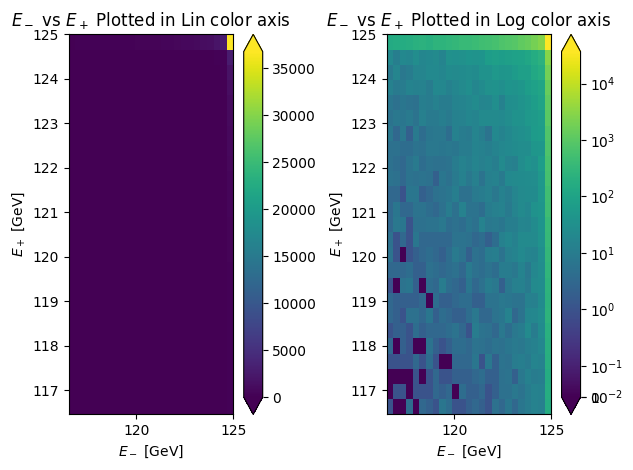

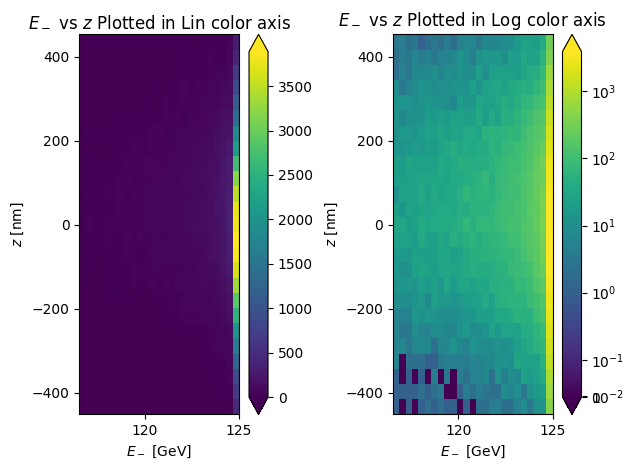

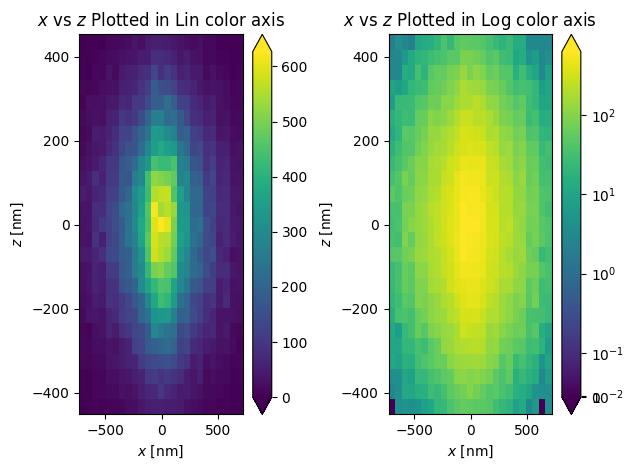

In [ ]:
#Author: Brendon Madison , brendon_madison@ku.edu

import numpy as np
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm, linregress, permutation_test
import matplotlib.pyplot as plt

#Generate model data
yinter = 5.0
slope = 2.0
num = 10000
pre = 1000e-6
alph = 1000 #If you are assuming this data is binomial then alpha really should be = to num here

print("Precision given: %0.2e" % pre)


#Data generator function for generating three data sets
#Generate set 1 with parameter precision of 1000 ppm and normal distribution
#Generate set 2 with parameter precision of 1000 ppm and beta distribution
#Generate set 3 with parameter precision of 1000 ppm with half from beta distribution, half from normal distribution
#Generate set 4 with stochastic noise of normal distribution with constant amplitude of 1000 pm * YINT
#This one is for generating a line
def data_gen_linear(PRECISION,ALPHA,YINT,SLOPE,XAXIS,NUMPTS):
    #data points
    dp = np.ones(NUMPTS)*YINT + XAXIS*SLOPE
    #Datasets to be generated
    ds1 = []
    ds2 = []
    ds3 = []
    ds4 = []

    #Beta parameter values for the beta distributions
    bta = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION - 
        ALPHA*PRECISION*PRECISION)/(ALPHA*PRECISION*PRECISION - 1.0)
    bta3 = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION*2.0 - 
        ALPHA*PRECISION*PRECISION*2.0)/(ALPHA*PRECISION*PRECISION*2.0 - 1.0)
    #1-sigma amplitude of gaussian noise
    rg_amp = PRECISION*YINT

    print("Parameters for beta random numbers\n-----\nalpha = %0.2e \nbeta = %0.2e " % (alph,bta))
    print("Precision for stochastic gaussian noise\n-----\nsigma = %0.2e" % (rg_amp))

    #now we do a for loop to fill the datasets
    for i in range(len(dp)):
        ds1.append(np.random.normal(YINT,YINT*PRECISION,1) + 
            XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION,1))
        ds2.append(np.random.beta(ALPHA,bta,1)*YINT + 
            XAXIS[i]*np.random.beta(ALPHA,bta,1)*SLOPE)
        ds3.append(np.random.beta(ALPHA,bta3,1)*YINT*0.5 + 
            XAXIS[i]*np.random.beta(ALPHA,bta3,1)*SLOPE*0.5 + 
            np.random.normal(YINT,YINT*PRECISION*np.sqrt(2.0),1)*0.5 + 
            XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION*np.sqrt(2.0),1)*0.5)
        ds4.append(YINT + XAXIS[i]*SLOPE + 
            np.random.normal(0.0,rg_amp))
    ds1 = np.array(ds1).flatten()
    ds2 = np.array(ds2).flatten()
    ds3 = np.array(ds3).flatten()
    ds4 = np.array(ds4).flatten()
    return dp,ds1,ds2,ds3,ds4
    
def data_gen_para(PRECISION,ALPHA,YINT,SLOPE,XAXIS,NUMPTS):
    #data points
    dp = np.ones(NUMPTS)*YINT + XAXIS*XAXIS*SLOPE
    #Datasets to be generated
    ds1 = []
    ds2 = []
    ds3 = []
    ds4 = []

    #Beta parameter values for the beta distributions
    bta = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION - 
        ALPHA*PRECISION*PRECISION)/(ALPHA*PRECISION*PRECISION - 1.0)
    bta3 = (-1.0*ALPHA*ALPHA*PRECISION*PRECISION*2.0 - 
        ALPHA*PRECISION*PRECISION*2.0)/(ALPHA*PRECISION*PRECISION*2.0 - 1.0)
    #1-sigma amplitude of gaussian noise
    rg_amp = PRECISION*YINT

    print("Parameters for beta random numbers\n-----\nalpha = %0.2e \nbeta = %0.2e " % (alph,bta))
    print("Precision for stochastic gaussian noise\n-----\nsigma = %0.2e" % (rg_amp))

    #now we do a for loop to fill the datasets
    for i in range(len(dp)):
        ds1.append(np.random.normal(YINT,YINT*PRECISION,1) + 
            XAXIS[i]*XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION,1))
        ds2.append(np.random.beta(ALPHA,bta,1)*YINT + 
            XAXIS[i]*XAXIS[i]*np.random.beta(ALPHA,bta,1)*SLOPE)
        ds3.append(np.random.beta(ALPHA,bta3,1)*YINT*0.5 + 
            XAXIS[i]*XAXIS[i]*np.random.beta(ALPHA,bta3,1)*SLOPE*0.5 + 
            np.random.normal(YINT,YINT*PRECISION*np.sqrt(2.0),1)*0.5 + 
            XAXIS[i]*XAXIS[i]*np.random.normal(SLOPE,SLOPE*PRECISION*np.sqrt(2.0),1)*0.5)
        ds4.append(YINT + XAXIS[i]*XAXIS[i]*SLOPE + 
            np.random.normal(0.0,rg_amp))
    ds1 = np.array(ds1).flatten()
    ds2 = np.array(ds2).flatten()
    ds3 = np.array(ds3).flatten()
    ds4 = np.array(ds4).flatten()
    return dp,ds1,ds2,ds3,ds4



#For fitting and estimating the uncertainty of both parameters
#assumes a linear function: b + m*x
def fun_LL_line(params):
    #predicted y value
    yPred = params[0] + xdat*params[1]
    #The propagated variance
    #we assume that there is no uncertainty in x
    #we also assume our values are independent
    #You have to compute this using stuff like https://en.wikipedia.org/wiki/Propagation_of_uncertainty
    yVar = params[2]*params[2] + params[3]*params[3]*xdat*xdat
    LL = -np.sum(norm.logpdf(ydat,loc=yPred,scale=np.sqrt(yVar)))
    return(LL)
    
#For fitting and estimating the uncertainty of both parameters
#assumes a parabolic function: a + b*x*x
def fun_LL_para(params):
    #predicted y value
    yPred = params[0] + xdat*xdat*params[1]
    #The propagated variance
    #we assume that there is no uncertainty in x
    #we also assume our values are independent
    #You have to compute this using stuff like https://en.wikipedia.org/wiki/Propagation_of_uncertainty
    yVar = params[2]*params[2] + params[3]*params[3]*xdat*xdat*xdat*xdat
    LL = -np.sum(norm.logpdf(ydat,loc=yPred,scale=np.sqrt(yVar)))
    return(LL)
    
#For fitting and estimating the uncertainty of both parameters
#assumes a beta distribution: x^(a-1) * (1-x)^(b-1)
def fun_LL_beta(params):
    #predicted y value
    yPred = xdat**(params[0]-1.0) * (1.0-xdat)**(params[1] - 1.0)
    #the normalization
    yPred = yPred/np.amax(yPred)
    #The propagated variance
    #we assume that there is no uncertainty in x
    #we also assume our values are independent
    #You have to compute this using stuff like https://en.wikipedia.org/wiki/Propagation_of_uncertainty
    #Since this is a difficult equation just use wolfram alpha!
    alphvar = params[2]*params[2] * ((xdat**(params[0] - 1.0) * (1.0-xdat)**(params[1]) * np.log(xdat))/(xdat-1.0))**2
    betavar = params[3]*params[3] * ((xdat**(params[0] - 1.0) * (1.0-xdat)**(params[1]) * np.log(1.0-xdat))/(xdat-1.0))**2
    yVar = alphvar + betavar
    LL = -np.sum(norm.logpdf(ydat,loc=yPred,scale=np.sqrt(yVar)))
    return(LL)

def func(x,a,b):
    return a*x + b


def fit_linreg(XAXIS,DATABASE,NAME):
    #Scipy's least squares fit (linear regression)
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    lr = linregress(XAXIS,DATABASE)
    print("-----")
    print("%s linear regression fit" % NAME)
    print("m = %0.5e +- %0.5e, b = %0.5e +- %0.5e" % (lr.slope,lr.stderr,lr.intercept,lr.intercept_stderr))
    print("%s p-value %0.5e" % (NAME,lr.pvalue))
    
def fit_lsq(XAXIS,DATABASE,PINIT,NAME):
    #Scipy's optimize non-linear least squares fit
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    popt, pcov = curve_fit(func,XAXIS,DATABASE,p0=PINIT)

    print("-----")
    print("%s non-linear least squares fit" % NAME)
    print("m = %0.5e $\pm$ %0.5e \nb = %0.5e $\pm$ %0.5e" % (popt[0],np.sqrt(pcov[0][0]),popt[1],np.sqrt(pcov[1][1])))
    print("%s covariance matrix" % NAME)
    print(pcov)    

def fit_LL(XAXIS,DATABASE,PINIT,NAME):
    #Compute the fit using scipy's minimize with a user define function
    #Minimize https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    #also reference for the res variable https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
    #Setting these global variables sets the values in the fit function
    global ydat 
    ydat = DATABASE
    global xdat 
    xdat = XAXIS
    #We use the user defined fun_LL_line which computes log likelihood for a line and uncertainty on both parameters
    #By using the 'L-BFGS-B' method scipy can calculate the inverse hessian matrix (covariance matrix)
    #Though sometimes it will fail!
    res = minimize(fun_LL_line,PINIT,method='L-BFGS-B',tol=1e-30, options={'fatol': 1e-30})
    #res = minimize(fun_LL_para,PINIT,method='L-BFGS-B',tol=1e-30, options={'fatol': 1e-30})

    print("-----")
    print("%s 2D log likelihood for the parameters and their uncertainties" % NAME)
    print("m = %0.5e $\pm$ %0.5e \nb = %0.5e $\pm$ %0.5e" % (res.x[0],np.abs(res.x[2]),res.x[1],np.abs(res.x[3])))
    print("Hessian inverse (covariance matrix)")
    #Sometimes this can't be computed and will be an identity matrix!
    print(res.hess_inv.todense())

def data_get_pulls(FIT,DATABASE,ERR):
    #Takes the error value, the fit output and the database values
    #FIT and DATABASE should be arrays (or lists) of same length
    #ERR can be an array of same length OR a singular value
    #Computes the residuals R = DATABASE-FIT
    #and computes the pulls P = R/ERR
    res = []
    pull = []
    if len(ERR) == 1:
        for i in range(len(d1)):
            res.append(DATABASE[i] - FIT[i])
            pull.append((DATABASE[i] - FIT[i])/ERR)
    else:
        for i in range(len(d1)):
            res.append(DATABASE[i] - FIT[i])
            pull.append((DATABASE[i] - FIT[i])/ERR[i])
    return np.array(res), np.array(pull)

def ptest_statistic(DATA1,DATA2,axis):
    #The statistical test that permutation_test will use
    #See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html
    #for more detail
    #here we use the difference of the means
    return np.mean(DATA1,axis=axis) - np.mean(DATA2,axis=axis)

####################################################################################################################
####################################################################################################################
################################# MAIN PART OF CODE BELOW ##########################################################
####################################################################################################################
####################################################################################################################

#Get our data
xax = np.linspace(1,2,num)
datapoints, d1,d2,d3,d4 = data_gen_linear(pre,alph,yinter,slope,xax,num)

#Have to use this notation for scipy's minimize
xdat = xax
ydat = d1

#We assume poisson errors (sqrt of data)
#and then compute the residuals and pulls
res1 , pull1 = data_get_pulls(datapoints,d1,np.sqrt(d1))
res2 , pull2 = data_get_pulls(datapoints,d2,np.sqrt(d2))
res3 , pull3 = data_get_pulls(datapoints,d3,np.sqrt(d3))
res4 , pull4 = data_get_pulls(datapoints,d4,np.sqrt(d4))

#We compute the permutation test values
#This is to test if the databases are independent of the original datapoints or not
#(these should all be mean of 0 to indicate they are not independent)
ptest1 = permutation_test((datapoints,d1),ptest_statistic,n_resamples=10000,vectorized=True)
ptest2 = permutation_test((datapoints,d2),ptest_statistic,n_resamples=10000,vectorized=True)
ptest3 = permutation_test((datapoints,d3),ptest_statistic,n_resamples=10000,vectorized=True)
ptest4 = permutation_test((datapoints,d4),ptest_statistic,n_resamples=10000,vectorized=True)

print(ptest1.pvalue)
print("-----")
print("Pvalues from the permutation tests")
print("Database 1: %0.5e" % ptest1.pvalue)
print("Database 2: %0.5e" % ptest2.pvalue)
print("Database 3: %0.5e" % ptest3.pvalue)
print("Database 4: %0.5e" % ptest4.pvalue)

fig, axes = plt.subplots(2, 2)

#Plot the permutation test null distribution ... mostly to visualize the ptest
axes[1,1].set_title("Null Distribution of Ptest")
axes[1,1].hist(ptest1.null_distribution,bins=50,alpha=0.5,label='Gauss')
axes[1,1].hist(ptest2.null_distribution,bins=50,alpha=0.5,label='Beta')
axes[1,1].hist(ptest3.null_distribution,bins=50,alpha=0.5,label='G+B')
axes[1,1].hist(ptest4.null_distribution,bins=50,alpha=0.5,label='Stoch. G')
axes[1,1].legend()

#plot the data values so you can visualize what they look like
axes[0,0].set_title("Datasets with different noise types")
axes[0,0].plot(xax,d1,alpha=0.5,label='Gauss')
axes[0,0].plot(xax,d2,alpha=0.5,label='Beta')
axes[0,0].plot(xax,d3,alpha=0.5,label='G+B')
axes[0,0].plot(xax,d4,alpha=0.5,label='Stoch. G')
axes[0,0].legend()

#Making pull plots
axes[0,1].set_title("Pull plots of datasets")
axes[0,1].scatter(xax,pull1,alpha=0.5,label='Gauss')
axes[0,1].scatter(xax,pull2,alpha=0.5,label='Beta')
axes[0,1].scatter(xax,pull3,alpha=0.5,label='G+B')
axes[0,1].scatter(xax,pull4,alpha=0.5,label='Stoch. G')
axes[0,1].legend()

#Make histogram of pulls to show that they are the distributions we made them to be
axes[1,0].set_title("Histograms of pulls")
axes[1,0].hist(pull1,bins=25,range=(np.percentile(pull1,1),np.percentile(pull1,99)),alpha=0.5,label='Gauss')
axes[1,0].hist(pull2,bins=25,range=(np.percentile(pull2,1),np.percentile(pull2,99)),alpha=0.5,label='Beta')
axes[1,0].hist(pull3,bins=25,range=(np.percentile(pull3,1),np.percentile(pull3,99)),alpha=0.5,label='G+B')
axes[1,0].hist(pull4,bins=25,range=(np.percentile(pull4,1),np.percentile(pull4,99)),alpha=0.5,label='Stoch. G')
axes[1,0].legend()

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/REU_Crashcourse/LineStats.pdf")
plt.show()

#Do the linear regression fitting
fit_linreg(xax,d1,"Database 1")
fit_linreg(xax,d2,"Database 2")
fit_linreg(xax,d3,"Database 3")
fit_linreg(xax,d4,"Database 4")

#Do the least squares fitting
fit_lsq(xax,d1,[yinter*0.99,slope*0.99],"Database 1")
fit_lsq(xax,d2,[yinter*0.99,slope*0.99],"Database 2")
fit_lsq(xax,d3,[yinter*0.99,slope*0.99],"Database 3")
fit_lsq(xax,d4,[yinter*0.99,slope*0.99],"Database 4")

#Do the user defined log likelihood fitting
fit_LL(xax,d1,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 1")
fit_LL(xax,d2,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 2")
fit_LL(xax,d3,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 3")
fit_LL(xax,d4,[yinter*0.99,slope*0.99,0.001*yinter,0.001*slope],"Database 4")


#Open ended challenge

Let us read in lumi.ee.out again

The $E_-$ and $E_+$ histograms should follow a beta distribution.

So, using the LL method, try to fit the histograms.

Use the code from part 1 to import the data and then the code below to fit it. You will have to rewrite some things. Some notes:

1.) The beta distribution is only from 0 < x < 1 so you will need to transform the $E_-$ and $E_+$ data such that it is from 0 < x < 1

2.) The parameters are real and positive so 0 < $\alpha$ < $\infty$ and 0 < $\beta$ < $\infty$

3.) You need to use a new LL model since the error propagation is different

4.) You will need to guess some initial values. Try alpha=10 and beta=0.2 and then you can choose some value for the uncertainties

5.) You should (though don't have to) histogram the data before fitting it. So you will need to do that and choose its format.